# Многослойный перцептрон, грибы и ноутбуки

Осмотрим грибы

     poisonous cap-shape cap-surface cap-color bruises odor gill-attachment  \
0            p         x           s         n       t    p               f   
1            e         x           s         y       t    a               f   
2            e         b           s         w       t    l               f   
3            p         x           y         w       t    p               f   
4            e         x           s         g       f    n               f   
...        ...       ...         ...       ...     ...  ...             ...   
8119         e         k           s         n       f    n               a   
8120         e         x           s         n       f    n               a   
8121         e         f           s         n       f    n               a   
8122         p         k           y         n       f    y               f   
8123         e         x           s         n       f    n               a   

     gill-spacing gill-size gill-color  ... stalk-s

<Axes: >

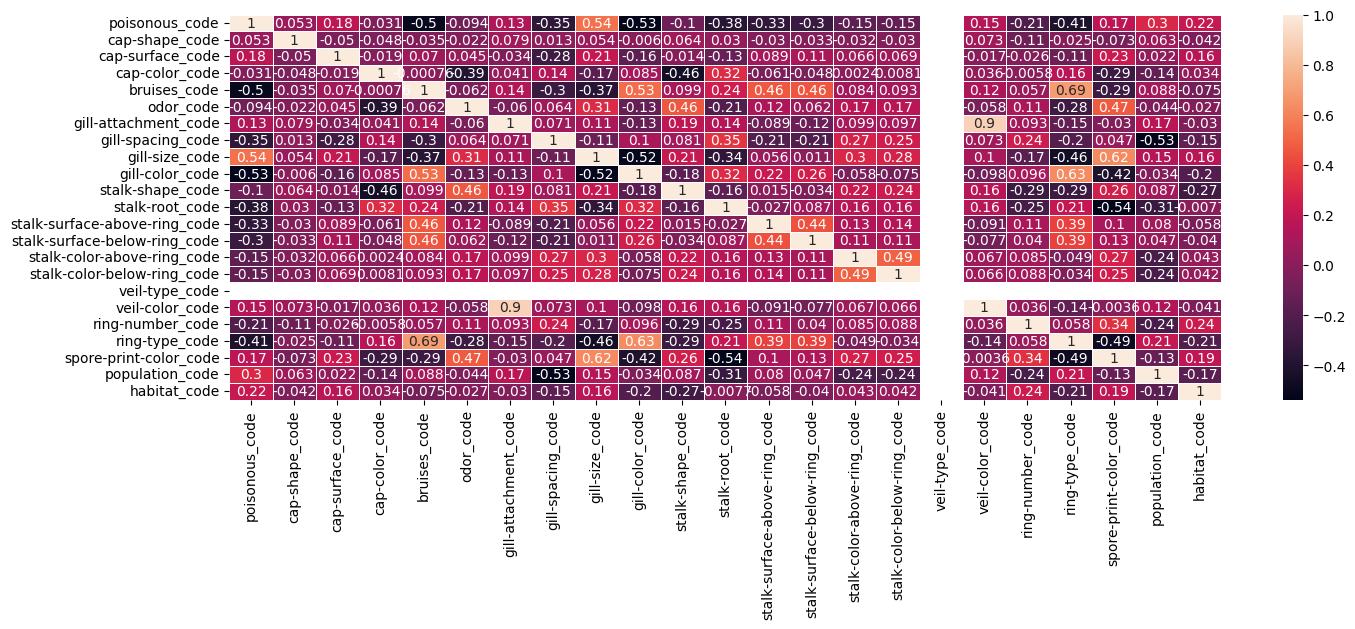

In [93]:
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('agaricus-lepiota.csv')
print(df)
df.isna()
label_encoder = LabelEncoder()

for label in df.columns:
  df[label +'_code'] = label_encoder.fit_transform(df[label])
  df = df.drop(label, axis=1)
plt.figure(figsize = (16,5))

sns.heatmap(df.corr(),annot=True, linewidths=.5)

In [94]:
# plt.figure(figsize = (16,5))
drop_labels = ["spore-print-color_code", "gill-color_code", "veil-color_code", "bruises_code"]
df = df.drop(columns = drop_labels, axis = 1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   poisonous_code                 8124 non-null   int32
 1   cap-shape_code                 8124 non-null   int32
 2   cap-surface_code               8124 non-null   int32
 3   cap-color_code                 8124 non-null   int32
 4   odor_code                      8124 non-null   int32
 5   gill-attachment_code           8124 non-null   int32
 6   gill-spacing_code              8124 non-null   int32
 7   gill-size_code                 8124 non-null   int32
 8   stalk-shape_code               8124 non-null   int32
 9   stalk-root_code                8124 non-null   int32
 10  stalk-surface-above-ring_code  8124 non-null   int32
 11  stalk-surface-below-ring_code  8124 non-null   int32
 12  stalk-color-above-ring_code    8124 non-null   int32
 13  stalk-color-below-

Accuracy: 1.0
Index(['cap-shape_code', 'cap-surface_code', 'cap-color_code', 'odor_code',
       'gill-attachment_code', 'gill-spacing_code', 'gill-size_code',
       'stalk-shape_code', 'stalk-root_code', 'stalk-surface-above-ring_code',
       'stalk-surface-below-ring_code', 'stalk-color-above-ring_code',
       'stalk-color-below-ring_code', 'veil-type_code', 'ring-number_code',
       'ring-type_code', 'population_code', 'habitat_code'],
      dtype='object')


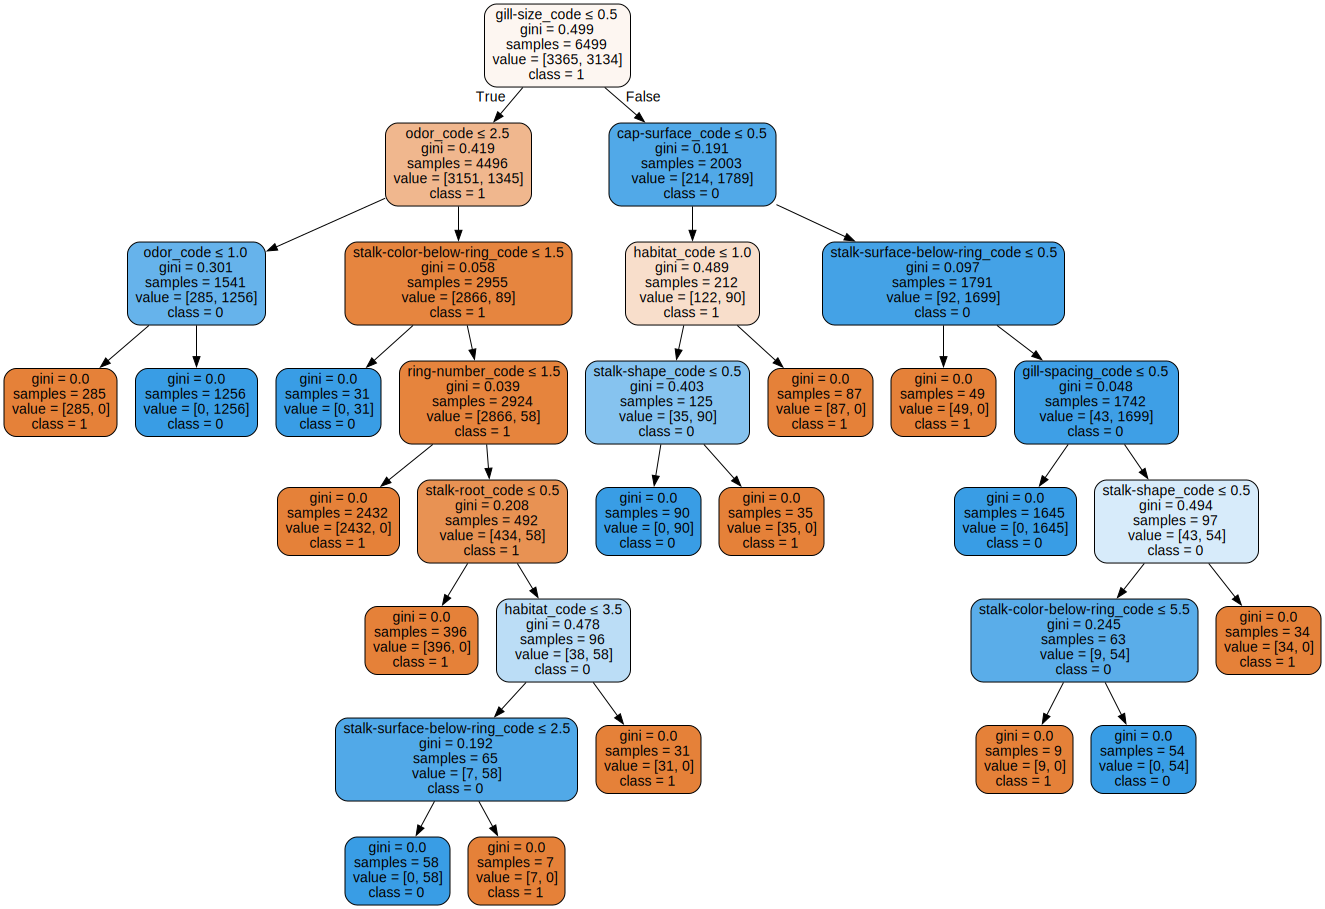

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# print(df)
X = df.drop(columns=['poisonous_code'])
y = df['poisonous_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_classifier = DecisionTreeClassifier()

# print(X_train, y_train)
tree_classifier.fit(X_train, y_train)

y_pred = tree_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(X.columns)
dot_data = export_graphviz(tree_classifier, out_file=None,
                           feature_names=list(X.columns),  # Convert feature names to list
                           class_names=list(map(str, y.unique())),  # Convert class names to string
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)

graph

In [96]:
importance = tree_classifier.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                          Feature  Importance
3                       odor_code    0.527712
6                  gill-size_code    0.301303
1                cap-surface_code    0.032088
10  stalk-surface-below-ring_code    0.031788
17                   habitat_code    0.026687
7                stalk-shape_code    0.025528
12    stalk-color-below-ring_code    0.022915
8                 stalk-root_code    0.017381
5               gill-spacing_code    0.011093
14               ring-number_code    0.003505
13                 veil-type_code    0.000000
16                population_code    0.000000
15                 ring-type_code    0.000000
0                  cap-shape_code    0.000000
11    stalk-color-above-ring_code    0.000000
4            gill-attachment_code    0.000000
2                  cap-color_code    0.000000
9   stalk-surface-above-ring_code    0.000000


## Код MLP

Определим класс персептрона

In [97]:
import numpy as np


class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_hidden_layers = len(hidden_sizes)
        self.weights = []
        layers = [input_size] + hidden_sizes + [output_size]
        # print('Layers')
        # print(layers)
        for i in np.arange(0, len(layers) - 1):
            w = np.random.randn(layers[i], layers[i + 1])
            self.weights.append(w / np.sqrt(layers[i]))

    def save_weights(self, filename):
        np.savez(filename, *self.weights)

    def load_weights(self, filename):
        loaded_data = np.load(filename)
        self.weights = [loaded_data[key] for key in loaded_data.keys()]

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward_propagation(self, x):
        self.activations = [np.atleast_2d(x)]
        for layer in np.arange(0, len(self.weights) - 1):
            net = self.activations[layer].dot(self.weights[layer])
            out = self.sigmoid(net)
            self.activations.append(out)
        net = self.activations[-1].dot(self.weights[-1])
        self.activations.append(net)
        return self.activations[-1]

    def backward_propagation(self, x, y, learning_rate):
        deltas = [None] * (self.num_hidden_layers + 1)
        deltas[-1] = (y - self.activations[-1])
        for i in range(self.num_hidden_layers, 0, -1):
            deltas[i - 1] = np.dot(deltas[i], self.weights[i].T) * self.sigmoid_derivative(self.activations[i])

        # Обновление весов и смещений
        for i in range(self.num_hidden_layers + 1):
            self.weights[i] += learning_rate * np.dot(self.activations[i].T, deltas[i])

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            total_loss = 0
            for (x, target) in zip(X, y):
                output = self.forward_propagation(x)
                self.backward_propagation(x, target, learning_rate)
                total_loss += np.mean(np.abs(target - output))
            if epoch % 10 == 0:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(X)}')

    def predict(self, X):
        return self.forward_propagation(X)

    def calculate_loss(self, x, targets):
        targets = np.atleast_2d(targets)
        predictions = self.predict(x, add_bias=False)
        loss = 0.5 * np.sum((predictions - targets) ** 2)
        return loss


**Определим метрики для получения**

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, precision_score, recall_score


def count_accuracy(true_positive, true_negative, false_positive, false_negative) -> float:
    return (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)


def precision(true_positive, false_positive) -> float:
    return true_positive / (true_positive + false_positive)


def recall(true_positive, false_negative) -> float:
    return true_positive / (true_positive + false_negative)


def f_score(percision, recall) -> float:
    return 2 * percision * recall / (percision + recall)


def count_mushrooms_metrics(true_positive, true_negative, false_positive, false_negative):
    print("accuracy: " + str(count_accuracy(true_positive, true_negative, false_positive, false_negative)))
    print("precision: " + str(precision(true_positive, false_positive)))
    print("recall: " + str(recall(true_positive, false_negative)))
    print("f-score: " + str(f_score(precision(true_positive, false_positive), recall(true_positive, false_negative))))


def count_metrics(true, predicted):
    # Вычисляем precision и recall для каждого класса
    precision = precision_score(true, predicted, average=None)
    recall = recall_score(true, predicted, average=None)

    # Выводим precision и recall для каждого класса
    for i in range(len(precision)):
        print("Class {}: Precision = {:.4f}, Recall = {:.4f}".format(i, precision[i], recall[i]))

    # Также можно вычислить средневзвешенное precision и recall
    weighted_precision = precision_score(true, predicted, average='weighted')
    weighted_recall = recall_score(true, predicted, average='weighted')
    print("Weighted Precision:", weighted_precision)
    print("Weighted Recall:", weighted_recall)


def compute_tpr_fpr(predictions, true_labels):
    thresholds = sorted(set(predictions), reverse=True)
    tprs = []
    fprs = []

    for threshold in thresholds:
        binarized_predictions = [1 if pred >= threshold else 0 for pred in predictions]

        tp = sum((p == 1 and t == 1) for p, t in zip(binarized_predictions, true_labels))
        fp = sum((p == 1 and t == 0) for p, t in zip(binarized_predictions, true_labels))
        tn = sum((p == 0 and t == 0) for p, t in zip(binarized_predictions, true_labels))
        fn = sum((p == 0 and t == 1) for p, t in zip(binarized_predictions, true_labels))

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        tprs.append(tpr)
        fprs.append(fpr)

    return tprs, fprs


def auc_manual(fpr, tpr):
    auc_score = 0
    n = len(fpr)
    for i in range(1, n):
        auc_score += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2
    return auc_score


def custom_roc_curve(predictions, target):
    tpr, fpr = compute_tpr_fpr(predictions, target)
    roc_auc = auc_manual(fpr, tpr)
    print("AUC-ROC (Custom):", roc_auc[0])
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Custom)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Custom)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.show()


def sklearn_roc_curve(predictions, target):
    fpr, tpr, thresholds = roc_curve(target, predictions)

    # Вычисляем площадь под ROC-кривой (AUC)
    roc_auc = auc(fpr, tpr)
    print("AUC-ROC (SKlearn):", roc_auc)

    # Строим ROC-кривую
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (SKlearn)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (SKlearn)')
    plt.legend()
    plt.show()


Определим к какому классу относятся ноутбуки

In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


def preprocess_data():
    label_encoder = LabelEncoder()
    df = pd.read_csv('data.csv')

    df['Storage_Capacity' + '_code'] = label_encoder.fit_transform(df['Storage_Capacity'])
    df = df.drop('Storage_Capacity',axis=1)

    column_names = ['Storage_Capacity_code', 'Processor_Speed', 'Weight', 'Screen_Size', 'RAM_Size','Price']
    selected_columns = df[column_names]

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(selected_columns)
    normalized_data = pd.DataFrame(scaled_data, columns=selected_columns.columns)

    target = normalized_data['Price']
    target = pd.qcut(target, q=5, labels=['Very low', 'Low', 'Medium', 'High', 'Very high'])
    target = label_encoder.fit_transform(target)
    target_array = np.array([[x] for x in target])

    normalized_data = normalized_data.drop('Price',axis=1)
    incoming_params = normalized_data.to_numpy()

    return incoming_params, target_array

def test_data():
    mlp = MLP(input_size=5, hidden_sizes=[20,20,20], output_size=5)
    mlp.load_weights("../saved_weights/new_new_weight_data_laptop.npz")
    total_error = 0

    predicted = []
    true = []

    for (x, target) in zip(X_test, y_test):
        prediction = mlp.predict(x)
        true.append(target)
        ans = np.argmax(prediction)
        predicted.append(ans)
        total_error += 0 if ans == target[0] else 1
        # print("[INFO] data={}, ground-truth={}, pred={:.4f}".format(x, target[0], ans))
    print("Total error:", total_error / X_test.size)
    count_metrics(true, predicted)



def train_data():
    mlp = MLP(input_size=5, hidden_sizes=[20,20,20], output_size=5)
    # mlp.load_weights("new_new_weight_data_laptop.npz")
    for j in range(20):
        target = []
        print("Текущая: ", j)
        for i in target_array:
            array = [0] * 5
            array[int(i)] = 1
            target.append(array)
        X_train, X_test, y_train, y_test = train_test_split(incoming_params, target, test_size=0.2, random_state=42)
        mlp.train(X_train, y_train, epochs=200, learning_rate=0.1)
    mlp.save_weights("new_new_weight_data_laptop")


incoming_params, target_array = preprocess_data()
X_train, X_test, y_train, y_test = train_test_split(incoming_params, target_array, test_size=0.2, random_state=42)

# train_data()
test_data()


Total error: 0.032
Class 0: Precision = 0.8000, Recall = 0.7742
Class 1: Precision = 0.7400, Recall = 0.8605
Class 2: Precision = 0.7838, Recall = 0.8056
Class 3: Precision = 0.9111, Recall = 0.8913
Class 4: Precision = 0.9737, Recall = 0.8409
Weighted Precision: 0.8479471629524262
Weighted Recall: 0.84


Тестим грибы

Total error: 0.008
accuracy: 0.968
precision: 0.9919137466307277
recall: 0.9411764705882353
f-score: 0.9658792650918635
AUC-ROC (Custom): 0.9949751678483555


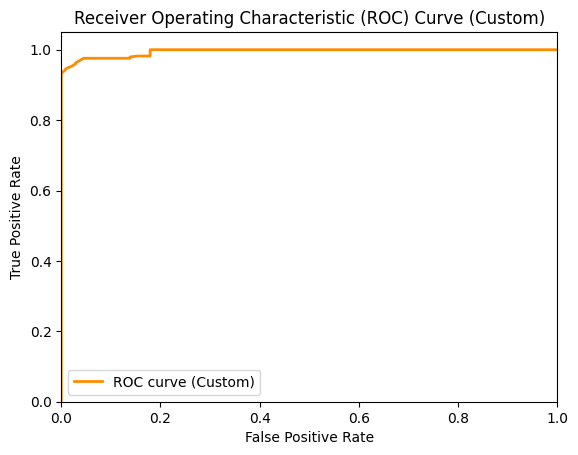

AUC-ROC (SKlearn): 0.9949751678483555


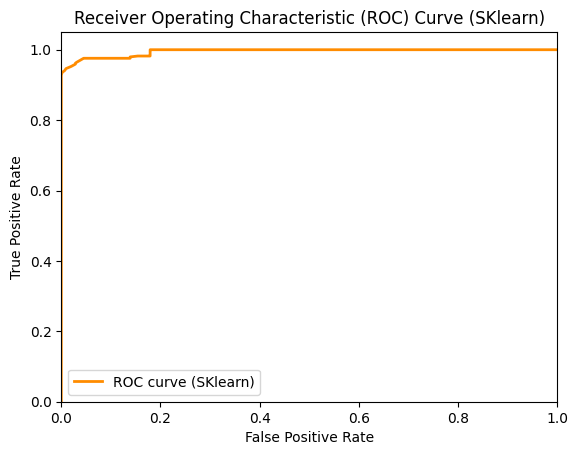

In [103]:
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def preprocess_agaricus():
    label_encoder = LabelEncoder()
    df = pd.read_csv('agaricus-lepiota.csv')
    for label in df.columns:
        most_common_value = df[label].mode()[0]
        df[label] = df[label].replace('?', most_common_value)


    for label in df.columns:
        df[label + '_code'] = label_encoder.fit_transform(df[label])
        df = df.drop(label, axis=1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    normalized_data = pd.DataFrame(scaled_data, columns=df.columns)

    column_names = ['gill-color_code', 'spore-print-color_code', 'population_code', 'gill-size_code']

    drop_labels = ["spore-print-color_code", "gill-color_code", "veil-color_code", "bruises_code"]
    df = df.drop(columns = drop_labels, axis = 1)

    selected_columns = normalized_data[column_names]
    incoming_params = selected_columns.to_numpy()


    target = normalized_data['poisonous_code'].to_numpy()
    target_array = target.reshape(-1, 1)
    return incoming_params, target_array

def test_mush():
    true_positive = 0
    true_negative = 0
    false_negative = 0
    false_positive = 0
    mlp = MLP(input_size=3, hidden_sizes=[3,4, 5], output_size=1)
    mlp.load_weights("../saved_weights/weights_mushrooms.npz")
    total_error = 0
    preds = []
    for (x, target) in zip(X_test, y_test):
        pred = mlp.predict(x)[0][0]
        preds.append(pred)
        step = 1 if pred > 0.7 else 0
        # print("[INFO] data={}, ground-truth={}, pred={:.4f}, step={}".format(x, target[0], pred, step))
        total_error += abs(step - target[0])
        if step == target == 1:
            true_positive += 1
        if step == target == 0:
            true_negative += 1
        if target == 0 and step != target:
            false_positive += 1
        if target == 1 and step != target:
            false_negative += 1
    print("Total error:", total_error / X_test.size)
    count_mushrooms_metrics(true_positive, true_negative, false_positive, false_negative)
    custom_roc_curve(preds, y_test)
    sklearn_roc_curve(preds, y_test)



def train_mush():
    mlp = MLP(input_size=4, hidden_sizes=[3,4, 5], output_size=1)
    X_train, X_test, y_train, y_test = train_test_split(incoming_params, target_array, test_size=0.2, random_state=42)
    mlp.load_weights("weights_mushrooms.npz")
    print("Тренировка началась!")
    mlp.train(X_train, y_train, epochs=1000, learning_rate=0.1)
    print("Weights were saved to weights_mushrooms")
    mlp.save_weights("weights_mushrooms")



incoming_params, target_array = preprocess_agaricus()
X_train, X_test, y_train, y_test = train_test_split(incoming_params, target_array, test_size=0.2, random_state=42)
# train_mush()
test_mush()


Training completed!
Accuracy: 1.0
ROC AUC: 1.0


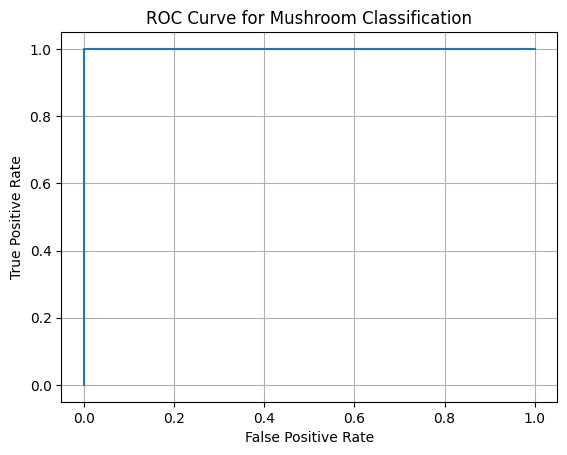

In [30]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

def preprocess_agaricus():
  df = pd.read_csv('agaricus-lepiota.csv')
  label_encoder = LabelEncoder()
  for col in df.columns[:-1]: 
    df[col] = label_encoder.fit_transform(df[col])
  target = df['poisonous']

  # Scale remaining features (excluding poisonous)
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(df.iloc[:, :-1])  # Exclude last column

  normalized_data = pd.DataFrame(scaled_data, columns=df.columns[:-1])
  selected_features = normalized_data

  return selected_features.to_numpy(), target.to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(incoming_params, target_array, test_size=0.2, random_state=42)
    
def train_mush():
    mlp = MLPClassifier(hidden_layer_sizes=[3, 4, 5], activation='relu', solver='adam', max_iter=1000)
    mlp.fit(X_train, y_train.ravel())
    print("Training completed!")
    joblib.dump(mlp, "weights_mushrooms.joblib")
    
def test_mush():
    mlp = joblib.load("weights_mushrooms.joblib")
    predictions = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy:", accuracy)
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC:", roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC=%0.4f)' % roc_auc)
    plt.title('ROC Curve for Mushroom Classification')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
incoming_params, target_array = preprocess_agaricus()
train_mush()
test_mush()
